# Install Dependencies

```
pip install geopandas                  
pip install PySAL                       
pip install descartes 
```


# Download "Countries"

Download the first link under "Admin 0 – Countries" for "Download countries" from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/

Unzip in your downloads directory. (Or any suitable location)


In [72]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import collections
import urllib2
import json
from shapely import geometry


os.environ["GOOGLE_CLOUD_PROJECT"] = "measurement-lab"

mlab_sites_config = 'https://storage.googleapis.com/operator-mlab-oti/metadata/v0/current/mlab-site-stats.json'

african_sites = ['jnb', 'cpt', 'mpm', 'tnr', 'nbo', 'los', 'acc', 'tun']

shapefile = os.path.expanduser('~/Downloads/ne_10m_admin_0_countries.shp')

colors = 9
cmap = 'Blues'
figsize = (16, 10)

In [2]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='measurement-lab'):
    #print query
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=300):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [29]:
globe_raw = gpd.read_file(shapefile)

globe = globe[['ISO_A2', 'CONTINENT', 'geometry']].to_crs('+proj=longlat')
africa = globe[globe.CONTINENT == 'Africa']

africa.sample(5)

,ISO_A2,CONTINENT,geometry
98,ML,Africa,"POLYGON ((-12.2641304119999 14.77493906700003,..."
125,RW,Africa,POLYGON ((29.01536543800011 -2.720711364999957...
122,MZ,Africa,(POLYGON ((32.11388431800009 -26.8400143429999...
27,MA,Africa,POLYGON ((-8.817034779999915 27.66146401100009...
36,NA,Africa,POLYGON ((16.48707116000008 -28.57293059699992...


# Clients Geolocated Within Africa

In [4]:
count_df = run_query("""
SELECT
  connection_spec.client_geolocation.country_name as country_name,
  connection_spec.client_geolocation.country_code as country_code,
  COUNT(*) as count
FROM
  `measurement-lab.ndt.base`
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-01")
  AND connection_spec.client_geolocation.continent_code = "AF"
GROUP BY
  country_code, country_name
ORDER BY
 country_name, country_code, count desc
""")

/usr/local/google/home/soltesz/.local/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
count_df.sample(5)

,count,country_code,country_name
37,50,SN,Senegal
9,7,CD,Congo
7,50,CM,Cameroon
6,9,CV,Cabo Verde
35,9,RW,Rwanda


In [6]:
count_merged = africa.merge(count_df, left_on='ISO_A2', right_on='country_code')
count_merged.sample(5)

,ISO_A2,CONTINENT,geometry,count,country_code,country_name
6,CG,Africa,"POLYGON ((18.62638716600009 3.476868998000072,...",3,CG,Republic of the Congo
33,GA,Africa,(POLYGON ((13.29456791200008 2.161057841000058...,13,GA,Gabon
44,ST,Africa,(POLYGON ((6.68140709700009 0.4071312520000561...,11,ST,São Tomé and Príncipe
22,AO,Africa,(POLYGON ((13.07370284000007 -4.63532318099996...,103,AO,Angola
13,SL,Africa,(POLYGON ((-10.28223587999989 8.48462534600010...,16,SL,Sierra Leone


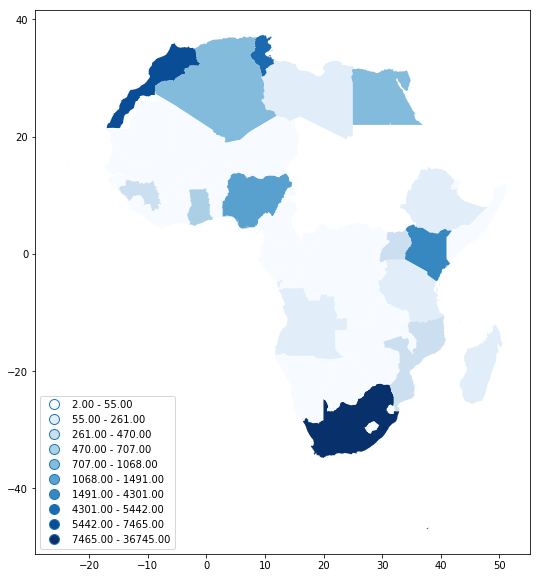

In [68]:
ax = count_merged.dropna().plot(column='count', cmap='Blues', figsize=figsize, scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})


In [73]:
response = urllib2.urlopen(mlab_sites_config)
sites = json.loads(response.read())

all_metros = {}
africa_metros = {}
for row in sites:
    all_metros[row['site'][0:3]] = (geometry.Point(row['longitude'], row['latitude'], ))
    if row['site'][0:3] in african_sites:
        africa_metros[row['site'][0:3]] = all_metros[row['site'][0:3]]
    
all_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(all_metros, orient='index', columns=['location']), geometry='location')
africa_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(africa_metros, orient='index', columns=['location']), geometry='location')

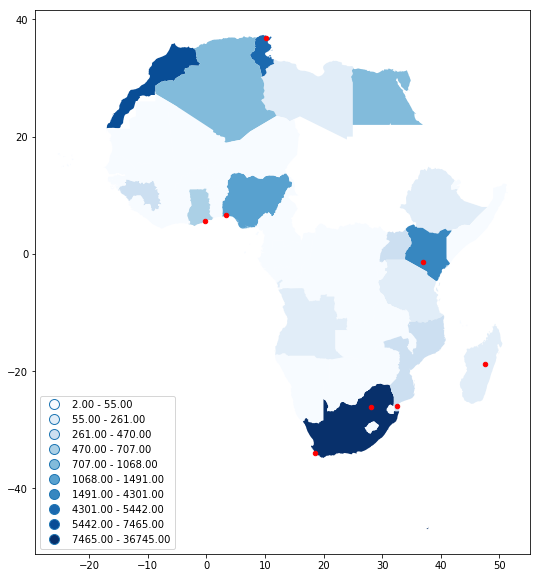

In [76]:
ax = count_merged.dropna().plot(column='count', cmap='Blues', figsize=figsize, scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})
africa_locations.plot(ax=ax, color='red', markersize=20)

In [8]:
rates_df = run_query("""
SELECT
  connection_spec.client_geolocation.country_name as country_name,
  connection_spec.client_geolocation.country_code as country_code,
  COUNT(*) as count,
  AVG(8 * (web100_log_entry.snap.HCThruOctetsAcked /
      (web100_log_entry.snap.SndLimTimeRwin +
       web100_log_entry.snap.SndLimTimeCwnd +
       web100_log_entry.snap.SndLimTimeSnd))) AS download_Mbps
       
FROM
  `measurement-lab.ndt.base`
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-01")
  AND connection_spec.client_geolocation.continent_code = "AF"

  AND connection_spec.data_direction = 1
  AND web100_log_entry.snap.HCThruOctetsAcked >= 8192
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) >= 9000000
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) < 600000000
  AND web100_log_entry.snap.CongSignals > 0
  AND (web100_log_entry.snap.State = 1 OR
    (web100_log_entry.snap.State >= 5 AND
    web100_log_entry.snap.State <= 11))
  
GROUP BY
  country_code, country_name
ORDER BY
 country_name, country_code, count desc
""")


Text(0.5,1,'Download Rates (Mbps)')

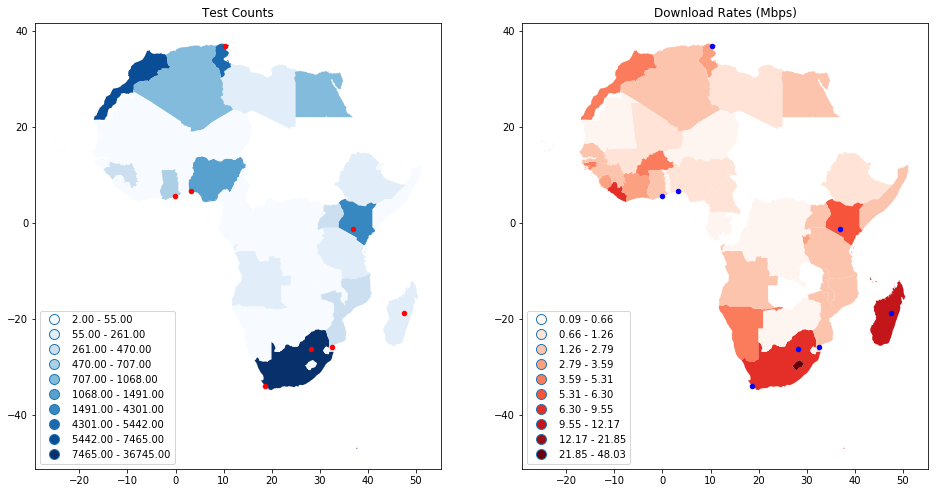

In [83]:
f, ax = plt.subplots(1, 2, figsize=figsize)

rates_merged = africa.merge(rates_df, left_on='ISO_A2', right_on='country_code')
ax1 = count_merged.dropna().plot(column='count', cmap='Blues', ax=ax[0], figsize=figsize, scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})
africa_locations.plot(ax=ax1, color='red', markersize=20)
ax2 = rates_merged.dropna().plot(column='download_Mbps', cmap='Reds', ax=ax[1], figsize=figsize, scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})
africa_locations.plot(ax=ax2, color='blue', markersize=20)

ax1.set_title('Test Counts')
ax2.set_title('Download Rates (Mbps)')

In [93]:

df_us_hops = {}
for site in ['lga', 'iad', 'atl', 'ord', 'den', 'dfw', 'sea', 'lax', 'nuq', 'mia']:
    print site
    df_us_hops[site] = run_query("""
select 
  paris_traceroute_hop.dest_geolocation.country_code as dest_country_code,
  count(*) as hops
from
  `measurement-lab.traceroute.base`
  
where
      TIMESTAMP_TRUNC(log_time, DAY) >= TIMESTAMP("2018-11-11")
  AND TIMESTAMP_TRUNC(log_time, DAY) <= TIMESTAMP("2018-11-12")
  AND REGEXP_CONTAINS(test_id, r"mlab[1-4].%s\d\d")
  AND connection_spec.client_geolocation.country_code = "US"

GROUP BY
  dest_country_code

ORDER BY
  hops desc
""" % site)

lga
iad
atl
ord
den
dfw
sea
lax
nuq
mia


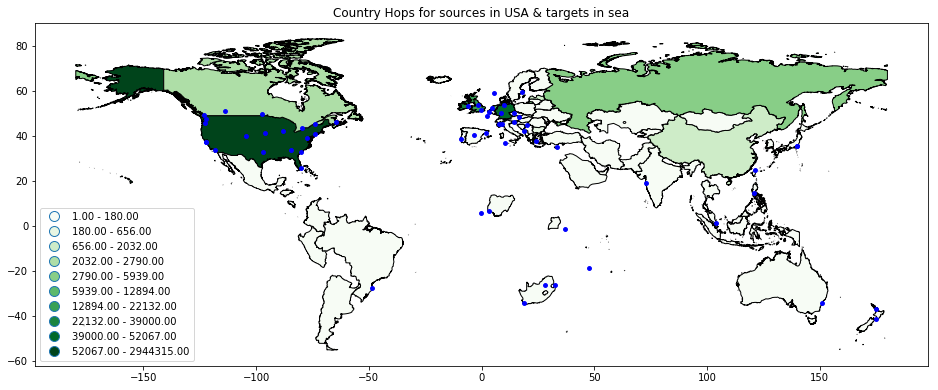

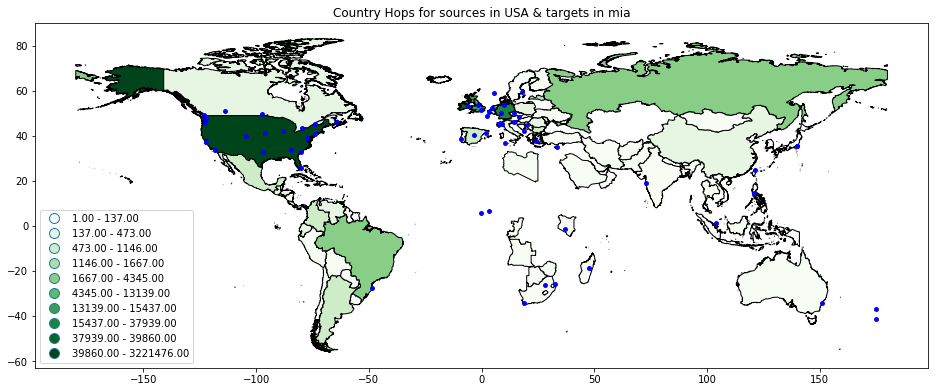

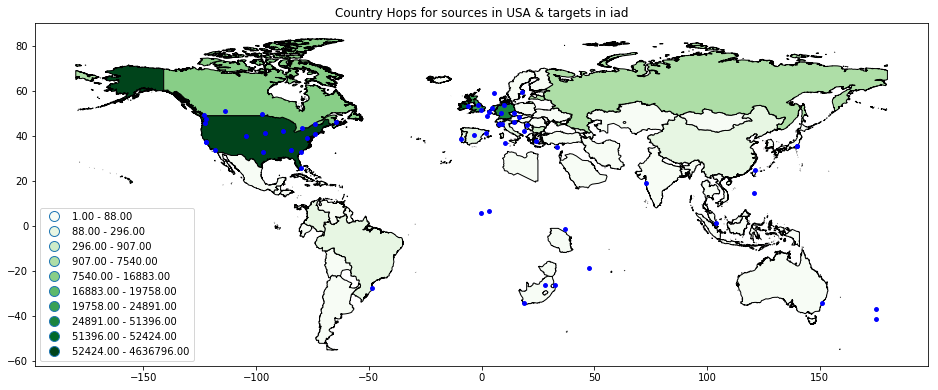

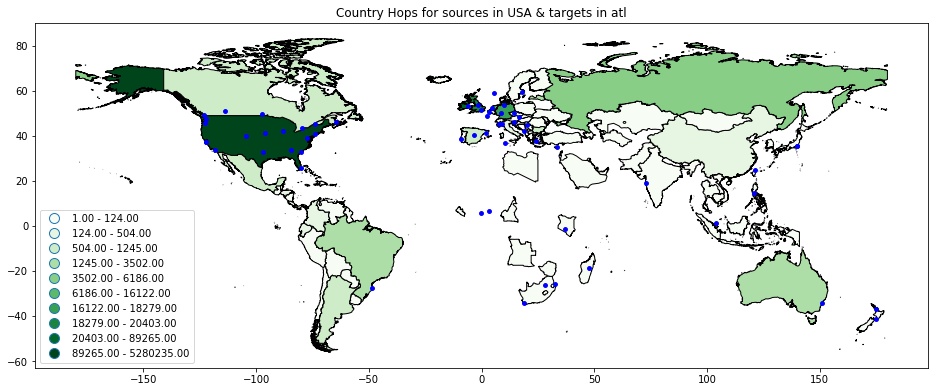

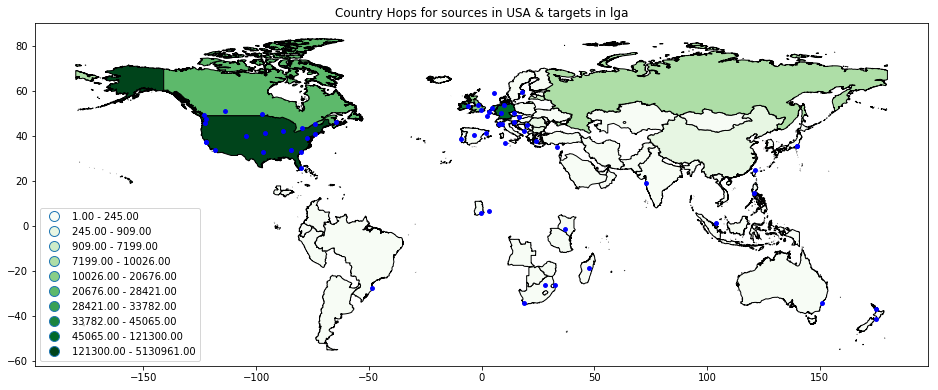

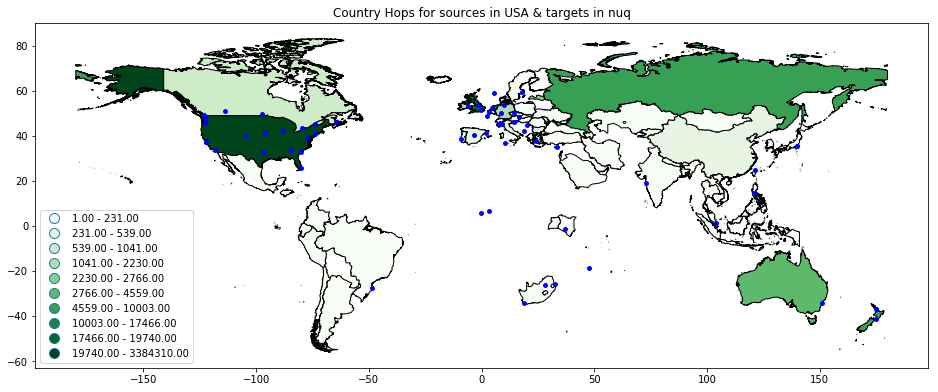

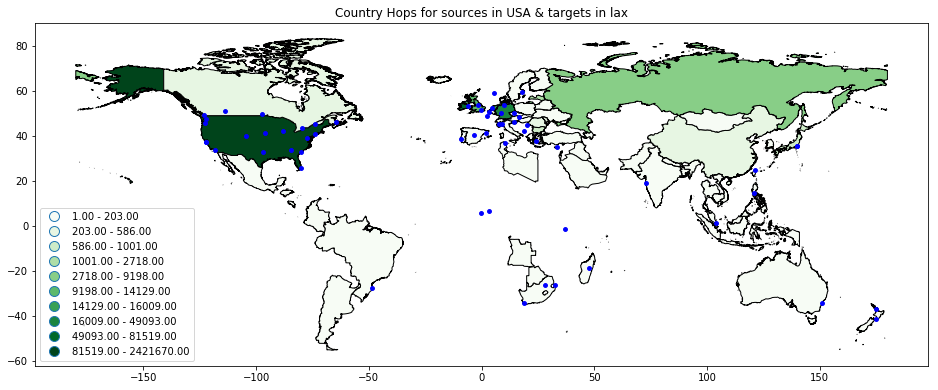

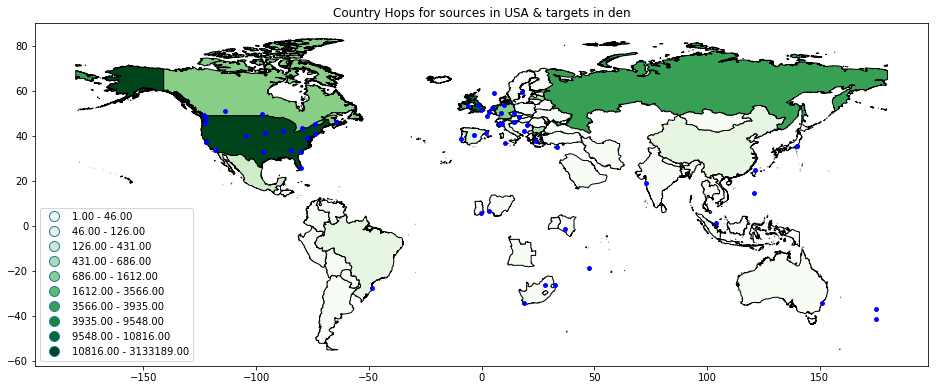

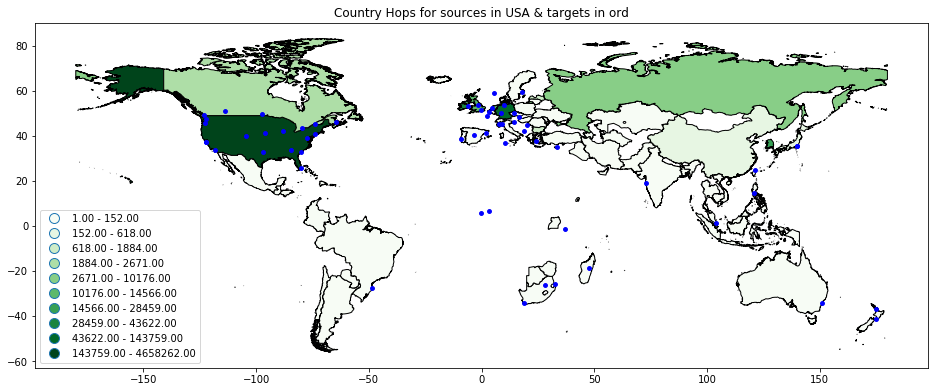

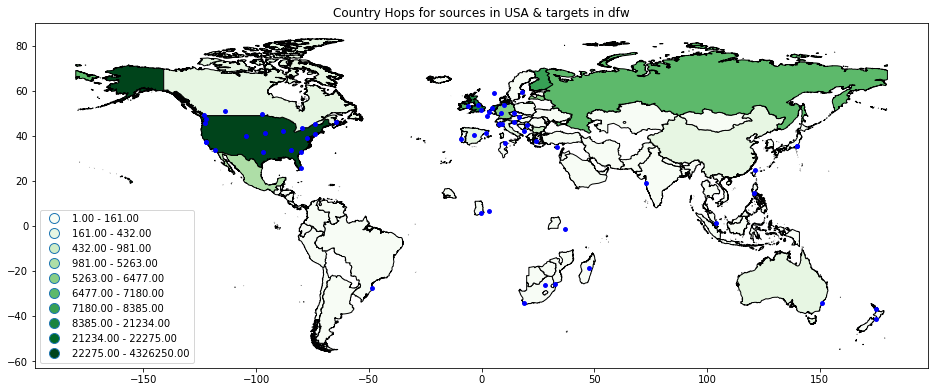

In [94]:
for site in df_us_hops:
    if not len(df_us_hops[site]):
        print "Skipping %s" % site
        continue
    hops_merged = globe.merge(df_us_hops[site], left_on='ISO_A2', right_on='dest_country_code')
    ax1 = hops_merged.dropna().plot(column='hops', cmap='Greens', figsize=(16,16), scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3}, edgecolor='black')
    ax1.set_title('Country Hops for sources in USA & targets in %s' % site)
    all_locations.plot(ax=ax1, color='blue', markersize=15)

In [33]:
df_hops = {}
for site in ['jnb', 'cpt', 'mpm', 'tnr', 'nbo', 'los', 'acc', 'tun']:
    print site
    df_hops[site] = run_query("""
select 
  paris_traceroute_hop.dest_geolocation.country_code as dest_country_code,
  count(*) as hops
from
  `measurement-lab.traceroute.base`
  
where
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-01")
  -- AND REGEXP_CONTAINS(test_id, r"mlab[1-4].(jnb|cpt|mpm|tnr|nbo|los|acc|tun)\d\d")
  AND REGEXP_CONTAINS(test_id, r"mlab[1-4].%s\d\d")
  AND connection_spec.client_geolocation.continent_code = "AF"

GROUP BY
  dest_country_code

ORDER BY
  hops desc
""" % site)

jnb
cpt
mpm
tnr
nbo
los
acc
tun


Skipping tun


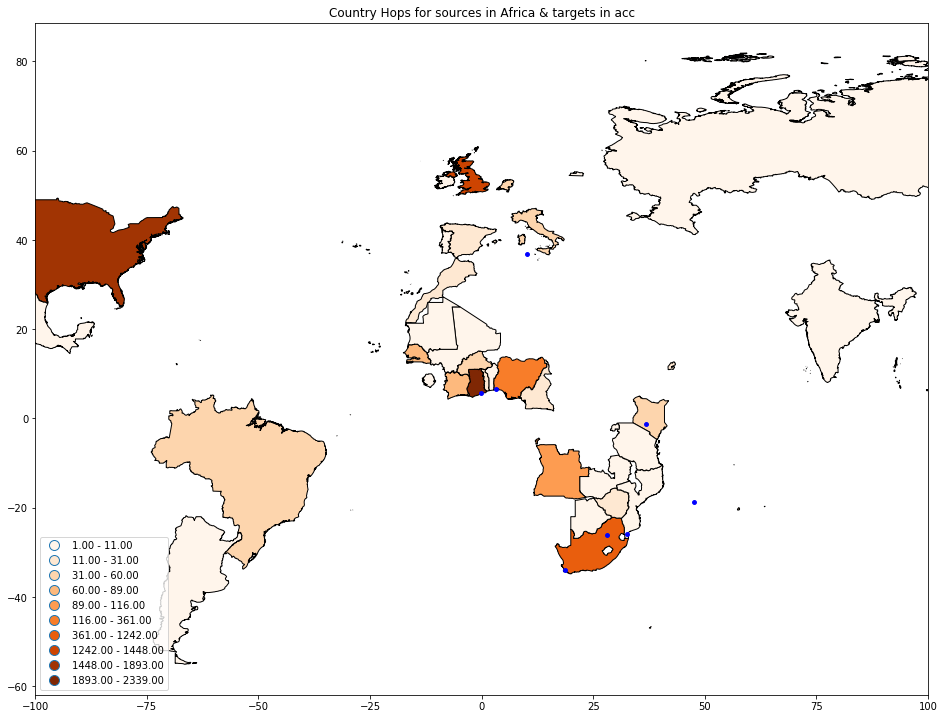

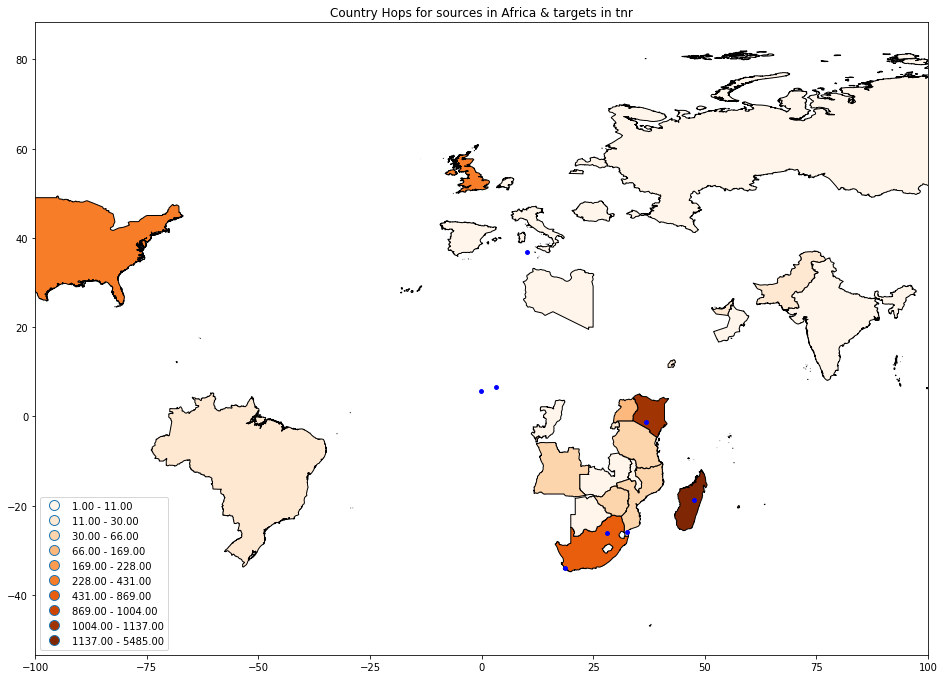

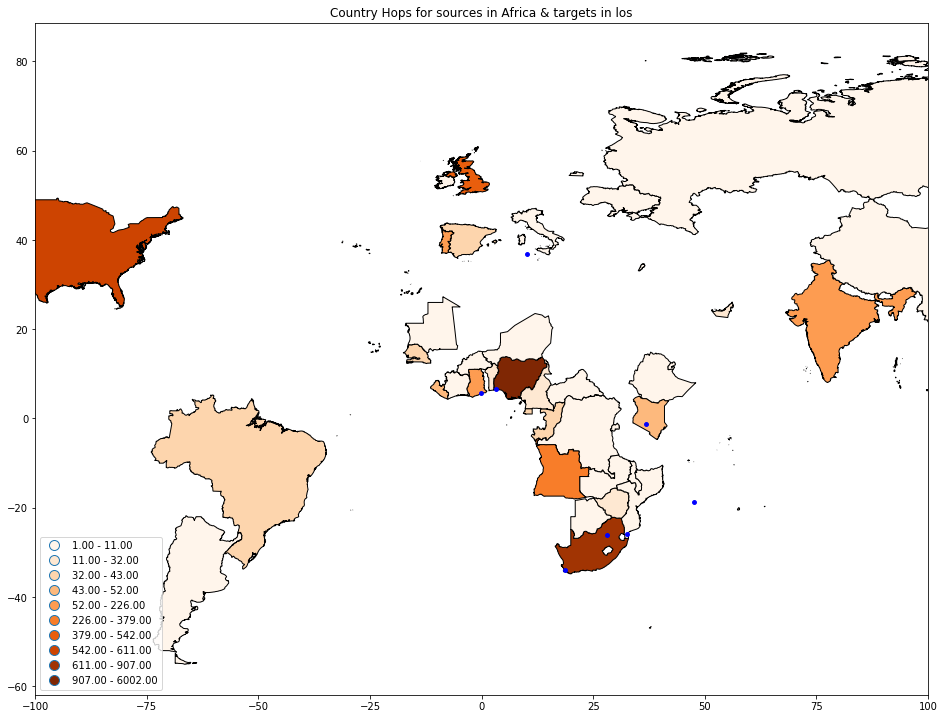

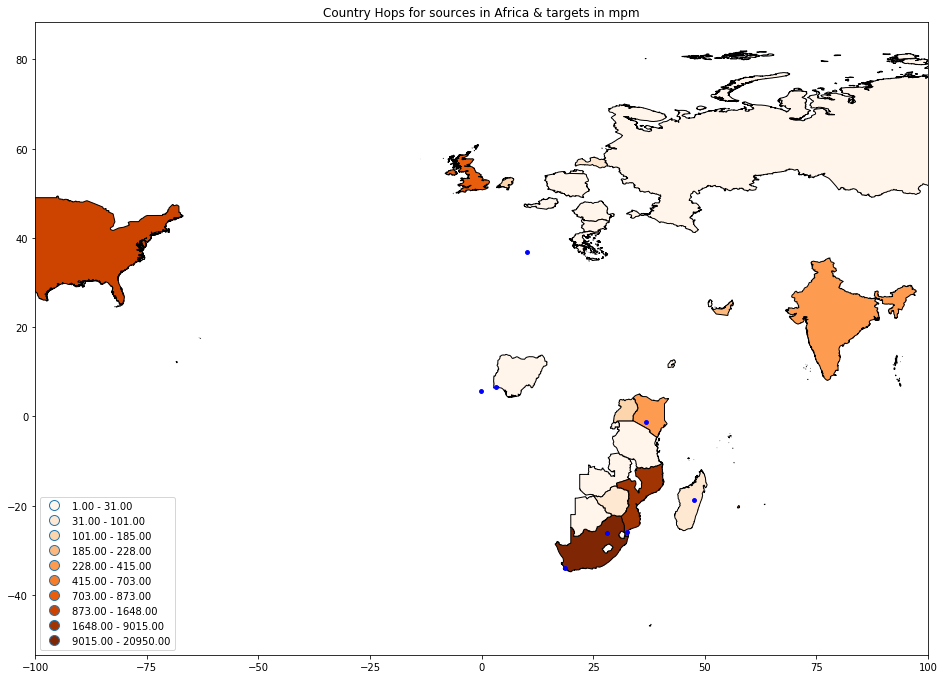

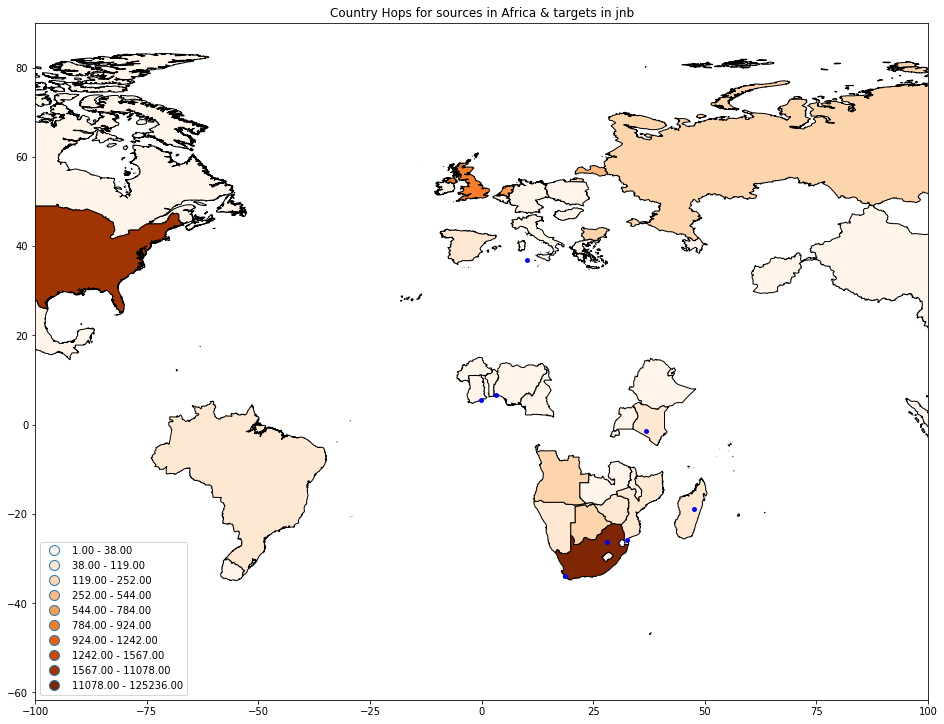

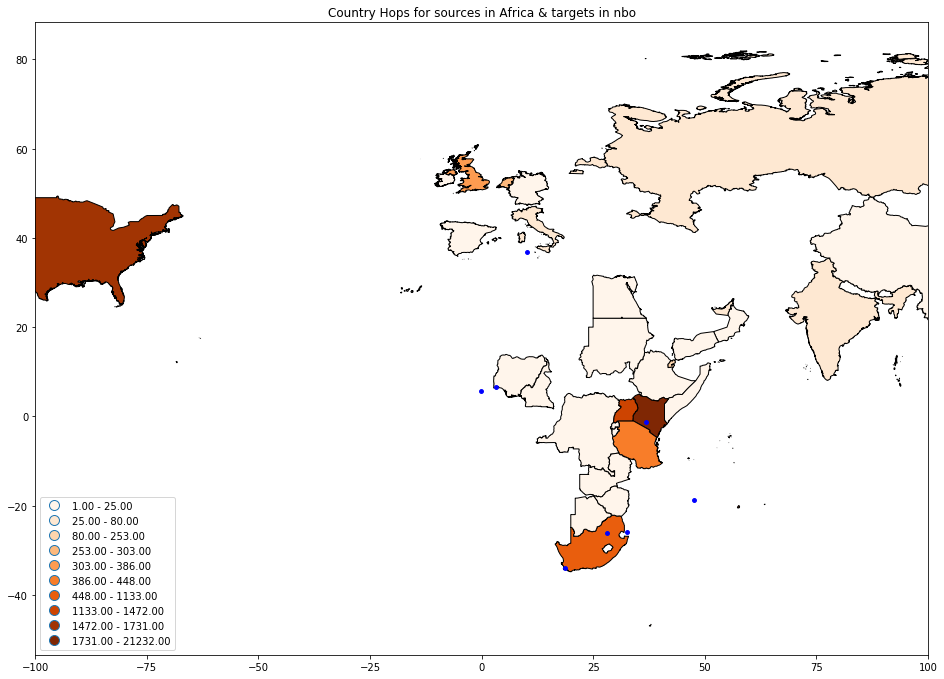

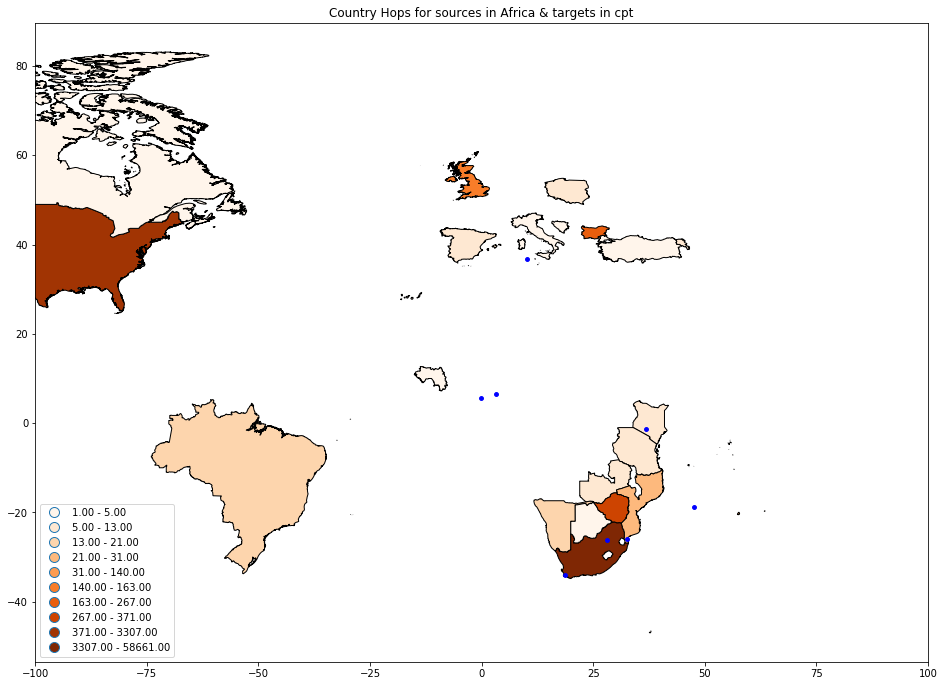

In [99]:
eu_af = globe # [(globe.CONTINENT == 'Africa') | (globe.CONTINENT == 'Europe') & (globe.ISO_A2 != 'RU')]

for site in df_hops:
    if not len(df_hops[site]):
        print "Skipping %s" % site
        continue
    hops_merged = eu_af.merge(df_hops[site], left_on='ISO_A2', right_on='dest_country_code')
    ax1 = hops_merged.dropna().plot(column='hops', cmap='Oranges', figsize=(16,16), scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3}, edgecolor='black')
    ax1.set_title('Country Hops for sources in Africa & targets in %s' % site)
    africa_locations.plot(ax=ax1, color='blue', markersize=15)
    ax1.set_xbound(-100, 100)
